# 1. **Import Libraries**
***
#### Import common libraries for data analysis.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.sparse import csr_matrix

plt.style.use('bmh')
sns.set_style('whitegrid')
pd.set_option('display.float', '{:.2f}'.format)

# 2. **Data Understanding**
***
## About the data
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from `MovieLens`, a movie recommendation service. It contains `100836` ratings and `3683` tag applications across `9742` movies. These data were created by `610` users between `March 29, 1996` and `September 24, 201`8. This dataset was generated on `September 26, 2018`.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

## Acknowledement:
***
*`F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.` [DOI: 10.1145/2827872](https://doi.org/10.1145/2827872)*
***

## The database file:  
The data are originally contained in the files *links.csv, movies.csv, ratings.csv* and *tags.csv*, but for ease of file orginizing I have combined them all into one sqlite .db file each as a table in it.
### `MovieLens.db`

In [3]:
import sqlite3 as sql

def run_query(q):
    with sql.connect("../BD00-Datasets/db-datasets/MovieLens.db") as conn:
        return pd.read_sql_query(q, conn)

## Data overview
***
### Movies Data File Structure (movies)
Movie information is contained in the table `movies` (originally movies.csv). Each line of this file after the header row represents one movie, and has the following format:

`movieId`, `title`, `genres`
- MovieId. These movie ids are consistent with those used on the MovieLens web site. Movie ids are consistent between ratings.csv, tags.csv, movies.csv, and links.csv. Only movies with at least one rating or tag are included in the dataset. 

### Ratings Data File Structure (ratings)
All ratings are contained in the table `ratings` (originally ratings.csv). Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

`userId`, `movieId`, `rating`, `timestamp`
- UserId. These User ids are consistent between ratings.csv and tags.csv. MovieLens users were selected at random for inclusion, their ids have been anonymized. 

### Tags Data File Structure (tags)
All tags are contained in the table `tags` (originally tags.csv). Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

`userId`, `movieId`, `tag`, `timestamp`

### Links Data File Structure (links)
Identifiers that can be used to link to other sources of movie data are contained in the table `links` (originally links.csv). Each line of this file after the header row represents one movie, and has the following format:

`movieId`, `imdbId`, `tmdbId`
- movieId is an identifier for movies used by movielens.org.
- imdbId is an identifier for movies used by imdb.com. 
- tmdbId is an identifier for movies used by themoviedb.org.

In [4]:
# inspecting data tables
run_query("""SELECT Name, type FROM sqlite_master WHERE type='table'""")

,name,type
0,movies,table
1,ratings,table
2,links,table
3,tags,table


## Get the datas
***
### Get the Movies and Ratings dataset

In [5]:
# Import the Movies dataset
movies = run_query("""SELECT * FROM movies""")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Import the ratings dataset
ratings = run_query("""SELECT * FROM ratings""")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.50,1260759144
1,1,1029,3.00,1260759179
2,1,1061,3.00,1260759182
3,1,1129,2.00,1260759185
4,1,1172,4.00,1260759205


In [7]:
print(f"The dataset contains: {len(ratings)} ratings of {len(movies)} movies.")

The dataset contains: 100004 ratings of 9125 movies.


# 3. **Data Preparation** 
***
## Exploratory Data Analysis (EDA)

### Taking a subset of users, and seeing what their preferred genres are.

In [8]:
def get_genre_ratings(ratings, movies, genres=None):
    col_names=[]
    if genres == None:
        genres = [x for x in movies.genres.unique() if all(y not in x for y in '|()')]

    genre_ratings = pd.DataFrame()
    for genre in genres:
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, 
                                          ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        col_names.append('Avg_'+genre+'_Rating')

    genre_ratings.columns = col_names
    return genre_ratings

In [9]:
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Thriller'])
genre_ratings.head()

,Avg_Romance_Rating,Avg_Thriller_Rating
1,3.50,2.83
2,3.59,3.33
3,3.65,3.55
4,4.50,4.02
5,4.08,3.62


def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings.iloc[:,0] < score_limit_1 - 0.2) 
                   & (genre_ratings.iloc[:,0] > score_limit_2)) 
                   | ((genre_ratings.iloc[:,1] < score_limit_1) 
                   & (genre_ratings.iloc[:,1] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records(), index=False)
    return biased_dataset

In [10]:
biased_dataset = genre_ratings[((genre_ratings.iloc[:,0] < 3.5 - 0.2) 
               & (genre_ratings.iloc[:,0] > 2.5)) 
               | ((genre_ratings.iloc[:,1] < 3.5) 
               & (genre_ratings.iloc[:,1] > 2.5))]
biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
biased_dataset = pd.DataFrame(biased_dataset.to_records()).fillna(method='ffill')
biased_dataset.rename(columns= {'index':'UserId'}, inplace=True)
#biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)

print(f"Number of records: {len(biased_dataset)}")
biased_dataset.head()

Number of records: 265


,UserId,Avg_Romance_Rating,Avg_Thriller_Rating
0,1,3.50,2.83
1,2,3.59,3.33
2,6,2.90,2.72
3,7,2.93,3.00
4,12,2.89,3.50


In [11]:
def draw_scatterplot(x_data, x_label, y_data, y_label, height=5, width=5):
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

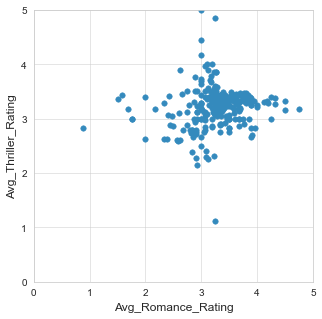

In [12]:
draw_scatterplot(biased_dataset.iloc[:,1], 
                 biased_dataset.columns.values[1], 
                 biased_dataset.iloc[:,2], 
                 biased_dataset.columns.values[2])

## Clustering (initial)
***
### Clustering to see group of users by genres they preferred

In [13]:
# Turn dataset into a list
X = biased_dataset.iloc[:,[1,2]].values

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

def evaluate_clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    cluster_centers = kmeans.cluster_centers_
    errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data, predictions)]
    return sum(errors)

def draw_clusters(biased_dataset, predictions, cmap='winter', height=5, width=5):
    fig = plt.figure(figsize=(width, height))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(biased_dataset.columns.values[1])
    ax.set_ylabel(biased_dataset.columns.values[2])
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered.iloc[:,2], clustered.iloc[:,3], c=clustered['group'], s=20, cmap=cmap)

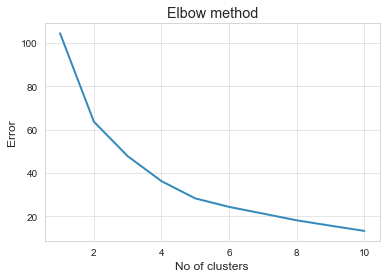

In [15]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(X)
    kmeans.fit(X)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()


Mean Squared Error: 31.85282


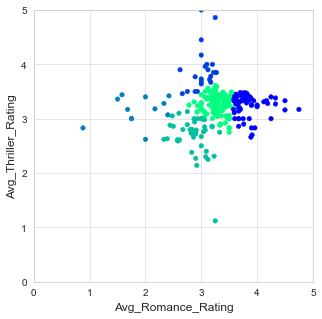

In [16]:
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=5)

# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X)
print(f"Mean Squared Error: {evaluate_clustering_errors(2, X):.5f}")

# Plot the cluster
draw_clusters(biased_dataset, predictions)

In [17]:
from sklearn.metrics import silhouette_samples, silhouette_score

def cluster_silhouette(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [39]:
# Choose the range of k values to test.
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
#possible_k_values = range(2, len(X)+2, 5)
possible_k_values = range(2, len(X)+1, 4)

# Calculate error values for all k values we're interested in
errors_per_k = [cluster_silhouette(k, X) for k in possible_k_values]

<ipython-input-17-e752b06cd4f2>:4: ConvergenceWarning: Number of distinct clusters (254) found smaller than n_clusters (258). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)
<ipython-input-17-e752b06cd4f2>:4: ConvergenceWarning: Number of distinct clusters (254) found smaller than n_clusters (262). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=k).fit(data)


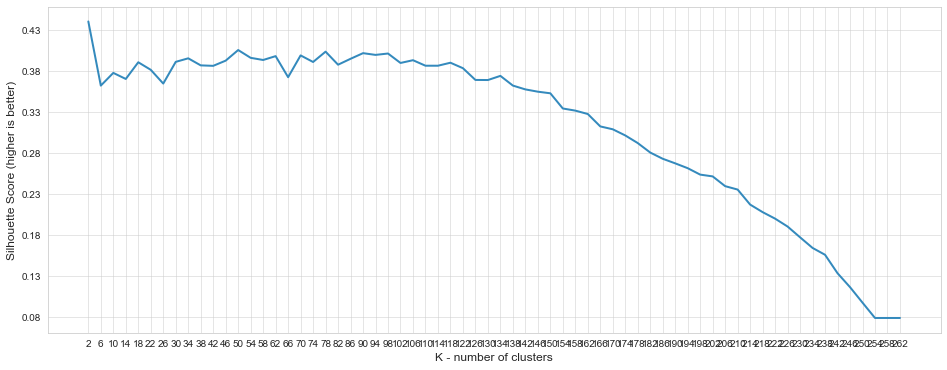

In [40]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlabel('K - number of clusters')
ax.set_ylabel('Silhouette Score (higher is better)')
ax.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 4.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')

yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

MSE: 10.58642


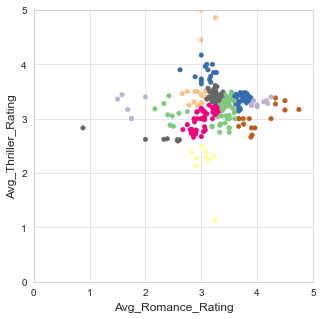

In [41]:
# TODO: Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=18)

# TODO: use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)
print(f"MSE: {evaluate_clustering_errors(7, X):.5f}")

# plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

In [42]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('dataset dimensions: ', user_movie_ratings.shape, '\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 
Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,nan,nan,nan,nan,nan,4.00,nan,nan


## Clustering (final)
***
### Clustering to see group of users by genres they preferred

In [43]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies
    
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    return most_rated_movies_users_selection

def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [44]:
n_movies = 50
n_users = 25
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (25, 50)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Mission: Impossible (1996),Groundhog Day (1993),Titanic (1997),"Princess Bride, The (1987)",Gladiator (2000),E.T. the Extra-Terrestrial (1982),"Terminator, The (1984)",Dumb & Dumber (Dumb and Dumber) (1994),"Mask, The (1994)",Good Will Hunting (1997)
72,5.00,5.00,5.00,4.50,4.50,4.00,4.50,5.00,5.00,3.00,...,3.00,4.00,0.50,5.00,4.00,4.00,4.50,3.50,2.00,4.00
653,4.00,5.00,5.00,4.50,5.00,4.50,5.00,5.00,5.00,5.00,...,4.50,4.00,5.00,4.50,4.00,5.00,4.50,4.00,4.50,4.00
508,4.00,5.00,4.00,4.00,5.00,3.00,4.50,3.00,5.00,2.00,...,nan,2.00,2.00,4.00,3.00,3.00,3.00,3.00,2.00,5.00
267,5.00,5.00,3.50,5.00,5.00,4.50,4.50,5.00,5.00,5.00,...,3.50,4.50,2.50,5.00,5.00,3.50,4.50,3.50,2.00,4.00
14,1.00,5.00,2.00,5.00,5.00,3.00,5.00,2.00,4.00,4.00,...,4.00,4.00,1.50,1.00,2.00,4.00,3.00,3.50,2.00,4.00


In [45]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True, width=6, height=6):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

    plt.show()

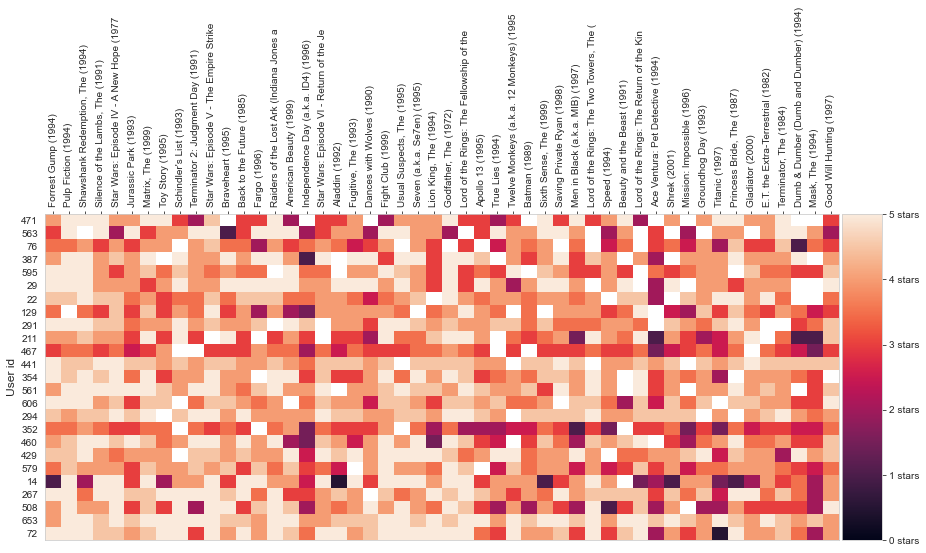

In [46]:
draw_movies_heatmap(most_rated_movies_users_selection, width=15)

In [47]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)

In [48]:
most_rated_movies_1k = most_rated_movies_1k.fillna(0)
most_rated_movies_1k

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Insomnia (2002),What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006)
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,3.00,4.00,0.00,3.00,0.00,4.00,0.00,0.00,4.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,5.00,4.50,5.00,3.00,0.00,0.00,0.00,0.00,3.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,5.00,5.00,0.00,0.00,5.00,5.00,0.00,0.00,0.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,4.00,5.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
667,0.00,5.00,4.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
668,0.00,0.00,0.00,0.00,5.00,3.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
669,0.00,0.00,5.00,5.00,0.00,0.00,4.00,4.00,5.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [50]:
#sparse_ratings = csr_matrix(pd.DataFrame(pd.arrays.SparseArray(most_rated_movies_1k)()))
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(most_rated_movies_1k)

In [51]:
def draw_movie_clusters(clustered, max_users, max_movies, height=5, width=5):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]

        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
           # print(f"MSE: {evaluate_clustering_errors(len(d), clustered):.5f}")
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(width, height))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


cluster # 10
# of users in cluster: 267. # of users in plot: 70


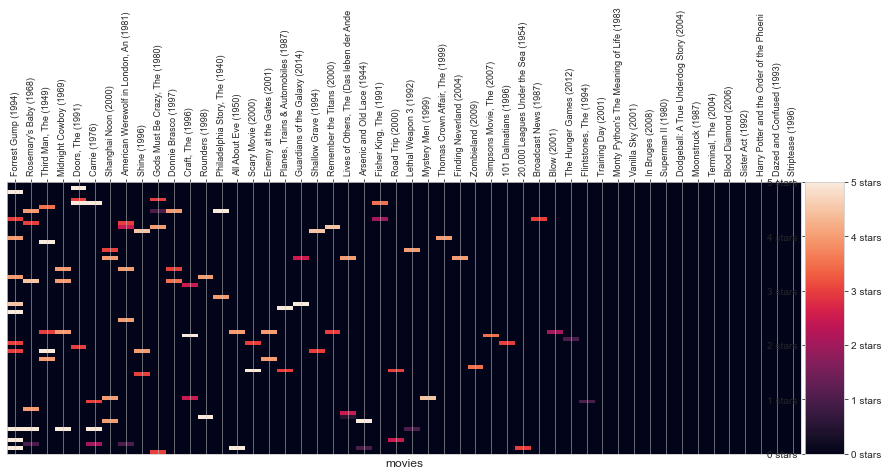

cluster # 7
# of users in cluster: 32. # of users in plot: 32


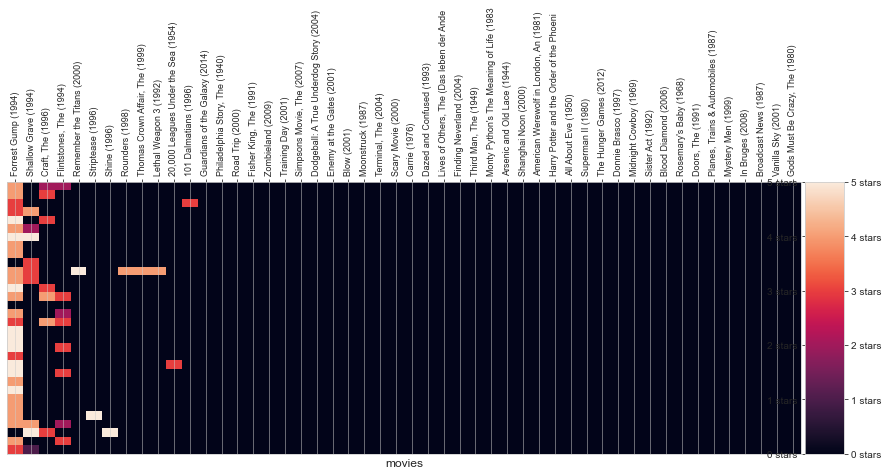

cluster # 4
# of users in cluster: 39. # of users in plot: 39


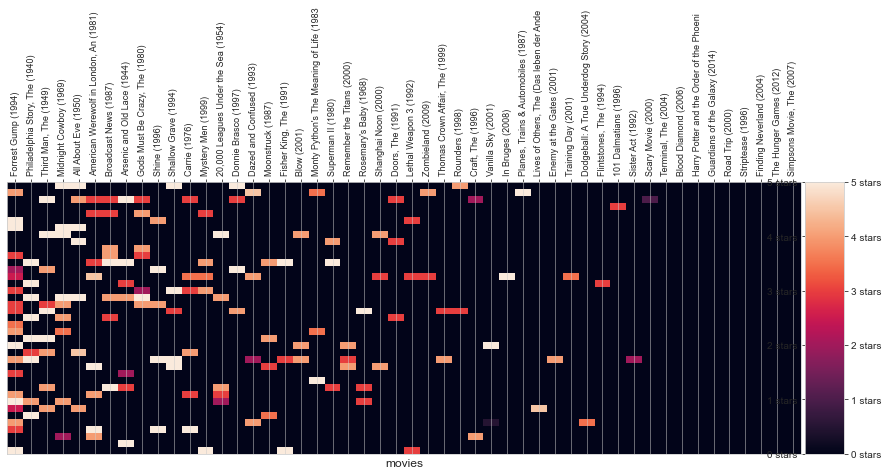

cluster # 6
# of users in cluster: 110. # of users in plot: 70


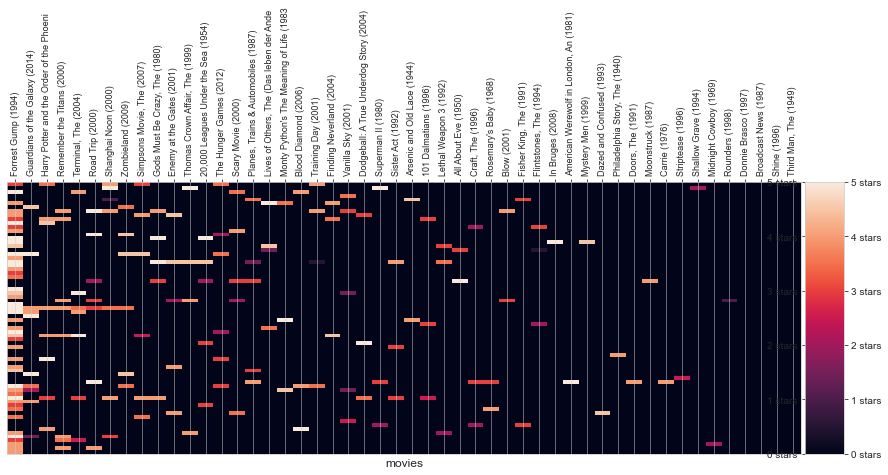

cluster # 1
# of users in cluster: 29. # of users in plot: 29


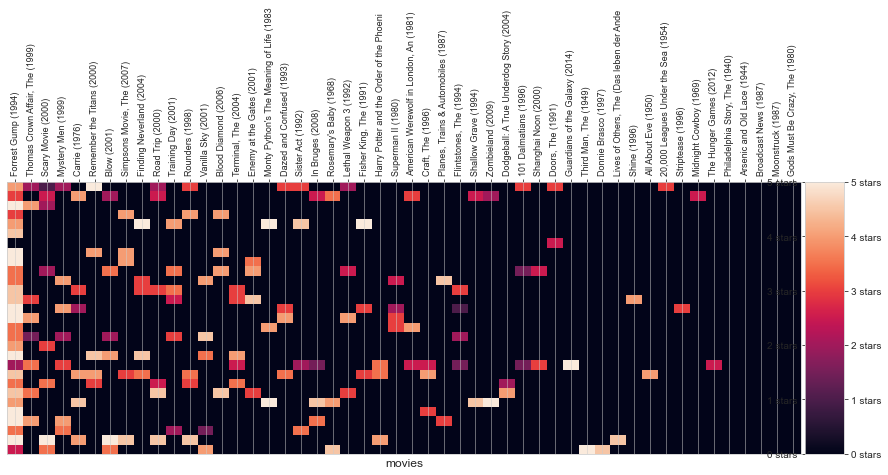

cluster # 0
# of users in cluster: 37. # of users in plot: 37


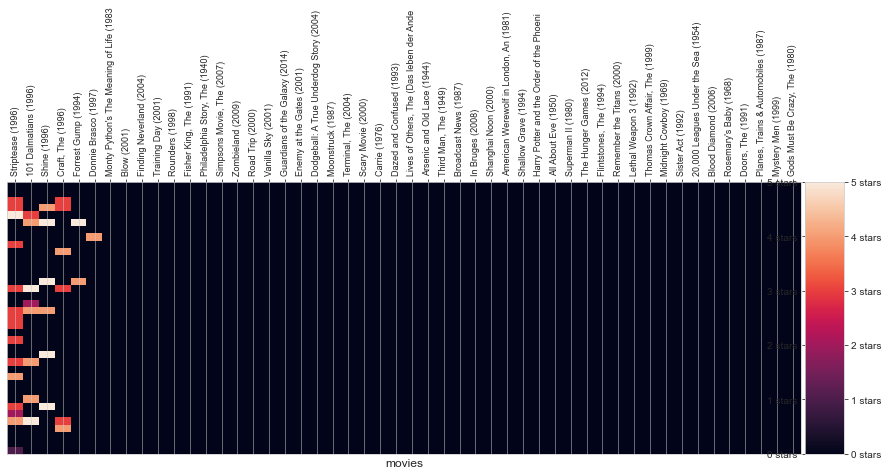

cluster # 2
# of users in cluster: 17. # of users in plot: 17


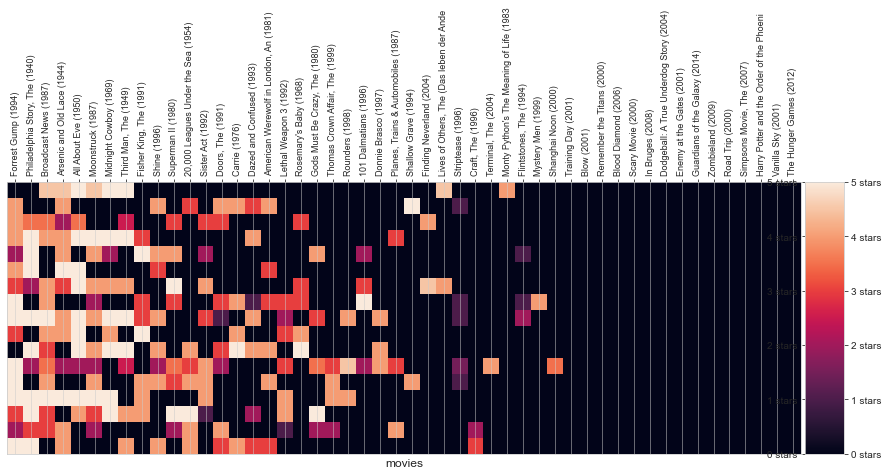

cluster # 16
# of users in cluster: 69. # of users in plot: 69


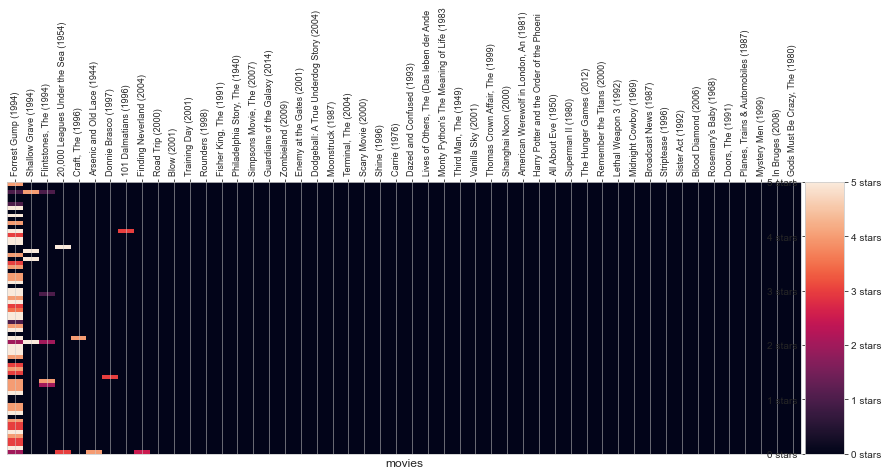

cluster # 8
# of users in cluster: 33. # of users in plot: 33


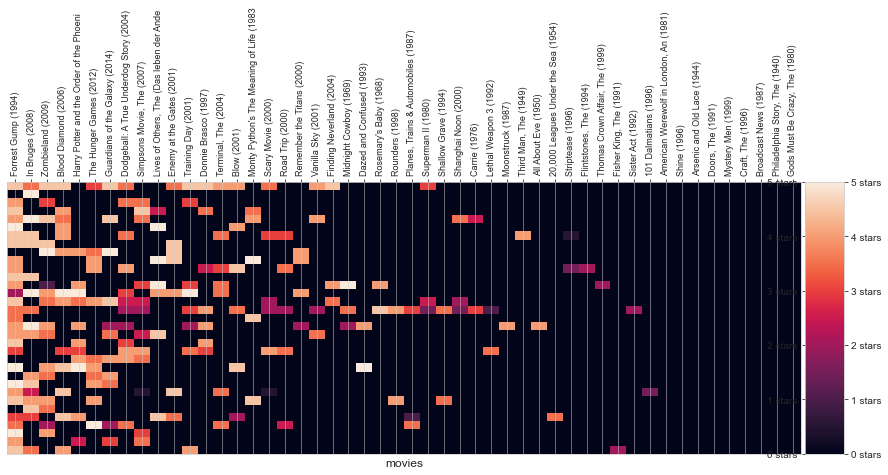

cluster # 19
# of users in cluster: 10. # of users in plot: 10


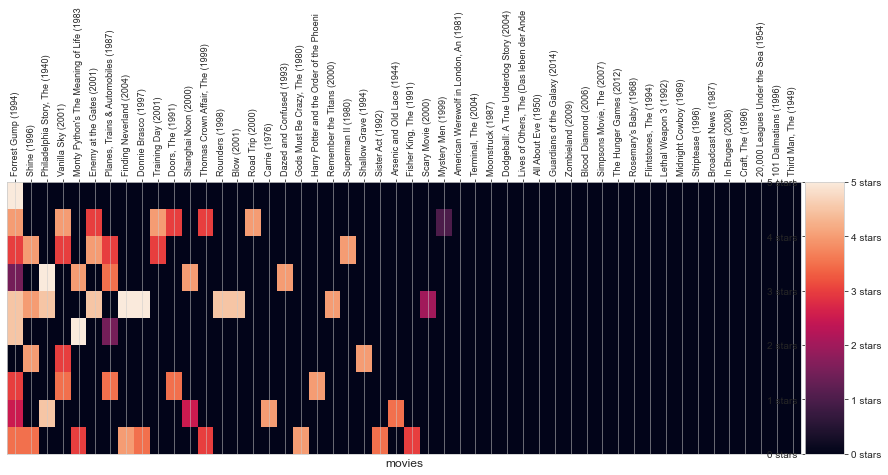

In [52]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies, width=15)

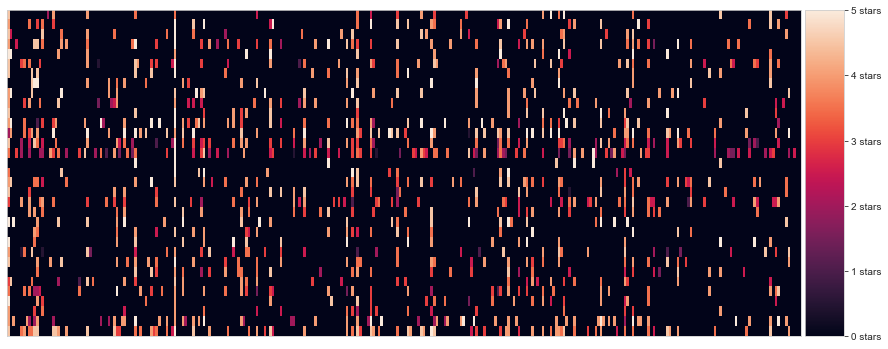

In [56]:
# Pick a cluster ID from the clusters above
cluster_number = 8

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False, width=15)

In [57]:
print("Cluster #13:")
cluster

Cluster #13:


,Forrest Gump (1994),"Lives of Others, The (Das leben der Anderen) (2006)",Dazed and Confused (1993),Carrie (1976),Shine (1996),Scary Movie (2000),"Terminal, The (2004)",Moonstruck (1987),Dodgeball: A True Underdog Story (2004),Enemy at the Gates (2001),...,Final Destination (2000),Mean Girls (2004),"Elephant Man, The (1980)",Ever After: A Cinderella Story (1998),Wallace & Gromit in The Curse of the Were-Rabbit (2005),Phone Booth (2002),"Walk in the Clouds, A (1995)",City Slickers (1991),Crimes and Misdemeanors (1989),Logan's Run (1976)
0,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00
17,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,0.00,...,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
31,4.50,2.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00
30,4.00,0.00,0.00,2.50,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
29,5.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
28,4.50,0.00,0.00,0.00,0.00,3.00,3.50,0.00,3.50,0.00,...,0.00,3.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
27,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
26,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25,4.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.50,...,0.00,0.00,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00
24,4.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,4.00,0.00,...,2.50,0.00,0.00,2.50,0.00,0.00,0.00,0.00,0.00,0.00


# **Deployment**
***
## Pick a movie subset

In [58]:
# Pick a movie from the table above since we're looking at a subset
movie_name = "Terminal, The (2004)"

cluster[movie_name].mean()

0.7424242424242424

## List 20 movies with average ratings from that cluster of user
***

In [59]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Forrest Gump (1994)                                   3.48
Lives of Others, The (Das leben der Anderen) (2006)   0.92
Dazed and Confused (1993)                             0.27
Carrie (1976)                                         0.17
Shine (1996)                                          0.00
Scary Movie (2000)                                    0.45
Terminal, The (2004)                                  0.74
Moonstruck (1987)                                     0.12
Dodgeball: A True Underdog Story (2004)               1.17
Enemy at the Gates (2001)                             0.88
Guardians of the Galaxy (2014)                        1.23
Zombieland (2009)                                     1.77
Road Trip (2000)                                      0.44
Simpsons Movie, The (2007)                            1.09
Philadelphia Story, The (1940)                        0.00
Fisher King, The (1991)                               0.06
Rounders (1998)                                       0.

## Recommend movies to a user in the cluster
***
* #### Pick a user ID from the cluster
* #### Get the movies they haven't rated yet
* #### List 10 recommended movies for that user based on the user cluster preferences

In [72]:
# Look at the cluster (#13) table above and pick one of the user ids (the first column in the table)
user_id = 5

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings == 0]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:10]

Hangover, The (2009)       2.41
Hot Fuzz (2007)            2.30
In Bruges (2008)           2.14
I Am Legend (2007)         1.85
Children of Men (2006)     1.80
Sherlock Holmes (2009)     1.76
Blood Diamond (2006)       1.62
Gangs of New York (2002)   1.36
Last Samurai, The (2003)   1.35
Moon (2009)                1.32
Name: 0, dtype: float64